In [ ]:
import numpy as np
import random

class Perceptron:
    
    def __init__(self, num_weights,learning_rate=0.01, iterations=1000):
        self.lr = learning_rate
        self.n_iters = iterations
        self.activation_func = self.sigmoid_func
        # initialising weights to a random value
        self.weights = np.random.randn(num_weights).reshape((num_weights,1))
        self.bias = 0
    
    #implementation of sigmoid/logistic function which always returns a value between 0 and 1
    def sigmoid_func(self, x):
        z = 1/(1 + np.exp(-x))
        return z

    def fit(self, x, y ):
        count, features = x.shape
        self.weights = np.zeros(features)
        self.bias = 0
        
        y1 = np.array([1 if i >= 0 else 0 for i in y])

        for i in range(self.n_iters):
            for idx, xi in enumerate(x):
                out = np.dot(xi, self.weights) + self.bias
                y_pred = self.activation_func(out)
                update = self.lr * (y[idx] - y_pred)
                self.weights += (update * xi)
                self.bias += update
   
    def stochastic_fit(self, x, y ):
        count, features = x.shape
        self.weights = np.zeros(features)
        self.bias = 0
        
        y1 = np.array([1 if i >= 0 else 0 for i in y])

        l = len(x)-1
        for i in range(self.n_iters):
            curr = random.randint(0,l)
            xi = x[curr]
            out = np.dot(xi, self.weights) + self.bias
            y_pred = self.activation_func(out)
            update = self.lr * (y[curr] - y_pred)
            self.weights += (update * xi)
            self.bias += update

    # find the predictions using the current state of weights
    def predict(self, x):
        out = np.dot(x, self.weights) + self.bias
        y_pred = self.activation_func(out)
        return y_pred
    
    def update_weight(self,wtchange):
      self.weights+=wtchange

    def get_weight(self):
      return self.weights
    
    def set_weight(self,newWeight):
      self.weights=newWeight     


In [ ]:
class Layer:

    # initialize a layer with number of perceptrons, type of layer and input as parameters
    def __init__(self,num_perceptrons,layer_type,input):
      self.num_perceptrons=num_perceptrons
      self.layer_type=layer_type
      self.input=input
      m,n=input.shape
      self.perceptron_list=[]
      for i in range(num_perceptrons):
        if(self.layer_type=="input"):
          p=Perceptron(1) # Input perceptron has only 1 weight
        else:  
          p=Perceptron(n) # Here, n is the number of weights that the perceptron has
        self.perceptron_list.append(p)
      self.output=self.generate_output(input)
      self.delta=None

    # function to calculate output of the layer in the form of a matrix  
    def generate_output(self,input):
      self.input=input
      out=None
      if (self.layer_type=="input"):
        for idx,p in enumerate(self.perceptron_list): 
          out=input
      else:
        for idx,p in enumerate(self.perceptron_list): 
          o=p.predict(input)
          if (out is None):
            out=o
          else:  
            out=np.append(out,o,axis=1)
      self.output=out
      return out

    # function to calculate local gradient(delta) of the layer in the form of a matrix
    def generate_delta(self,target,N):
      if (self.layer_type=="output"):
        delta=None
        # iterating through all perceptrons
        for idx,p in enumerate(self.perceptron_list):
          x=[]
          # iterating through all inputs
          for j in range(N):
            t=target[:,idx][j]
            y=self.get_output()[:,idx][j]
            d=-1*(t-y)*y*(1-y)             #using formula
            x.append(d)
          col= np.transpose(np.array([x]))
          if (delta is None):
            delta=col
          else:
            delta = np.append(delta,col,axis=1)
        self.delta=delta        

    def get_output(self):
      return self.output

    def get_input(self):
      return self.input

    def get_delta(self):
      return self.delta

    def get_perceptron_list(self):
      return self.perceptron_list

    def set_delta(self,d):
      self.delta=d 

    def get_type(self):
      return self.layer_type 

    def get_num_perceptrons(self):
      return self.num_perceptrons     

                     



In [ ]:
class MLP:
  # MLP class stores all the layers
  def __init__(self):
    self.num_layers=0
    self.layer_list=[]
  
  #function to add layer
  def addLayer(self,layer):
    self.layer_list.append(layer)
    self.num_layers+=1
  
  # function to calculate local gradient(delta) of the hidden layer in the form of a matrix
  def generate_delta_hidden(self,layer,idx,N):
    nextLayer=self.layer_list[idx+1]
    deltaNext=nextLayer.get_delta()
    p_list=layer.get_perceptron_list()
    p_next_list=nextLayer.get_perceptron_list()
    d=None
    # iterating through all perceptrons
    for idx,p in enumerate(p_list):
      arr=[]
      # iterating through all inputs
      for j in range(N):
        weightedSum=0
        for index,pnext in enumerate(p_next_list):         
          weight=pnext.get_weight()
          wt=weight[idx]
          deltaVal=deltaNext[:,index][j]
          x=wt*deltaVal
          weightedSum+=x
        y=layer.get_output()[:,idx][j]
        z=y*(1-y)*weightedSum 
        arr.append(z)
      
      col=(np.array(arr))
      if (d is None):
        d=col
      else:
        d=np.append(d,col,axis=1)  
    layer.set_delta(d)

  def backpropagate(self,N,learning_rate):
    for lIndex,l in enumerate(self.layer_list[::-1]):
      if(l.get_type()!="input"):
        delta=l.get_delta()
        y_input=l.get_input()
        # iterating through all perceptrons
        for idx,p in enumerate(l.get_perceptron_list()):
          wtchange=[]
          # iterating through all weights
          for wIndex,w in enumerate(p.get_weight()):
            gradient_sum=0
            # iterating through all inputs
            for j in range(N):
              # gradient = local gradient * y
              gradient=(delta[:,idx][j])*(y_input[:,wIndex][j]) 
              gradient_sum+=gradient
            # average gradient will be used in the final calculation of change in weight
            av_gradient=(gradient_sum/N) 
            # change in weight = - η*(average gradient)
            deltaW=-1*learning_rate*av_gradient 
            wtchange.append(deltaW)  
          wtchange_col= np.transpose(np.array([wtchange]))
          p.update_weight(wtchange_col)  
  
  
  def map_values(self,output,N):
    m=[]
    for j in range(N):
      if (output[j]>=0.5):
        m.append(1)
      else:
        m.append(0)
    mcol=np.transpose(np.array([m])) 
    return mcol

  # accuracy = true_predictions / total_predictions             
  def accuracy(self,target,output,N):
    y_pred=self.map_values(output,N)
    corr = 0
    for idx,pred_val in enumerate(y_pred):
        if (target[idx] == pred_val):
            corr = corr + 1
    return (corr/N)*100

          

**Implementation of the homework given in slide 4**

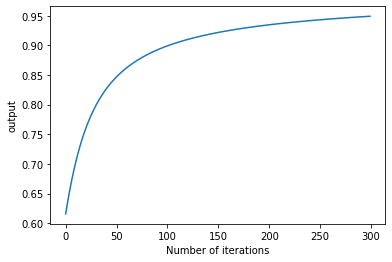

In [ ]:
import matplotlib.pyplot as plt
M1=MLP()
inp=np.array([[0.23,0.82]])
# initialising the layers
l1=Layer(2,"input",inp)
l2=Layer(2,"hidden",l1.get_output())
l3=Layer(1,"output",l2.get_output())

weightC=np.transpose(np.array([[0.1,0.4]]))
weightD=np.transpose(np.array([[0.5,0.3]]))
wlist=[weightC,weightD]
weightE=np.transpose(np.array([[0.2,0.6]]))

# setting the initial weights
for idx,p in enumerate(l2.get_perceptron_list()):
  p.set_weight(wlist[idx])

for idx,p in enumerate(l3.get_perceptron_list()):
  p.set_weight(weightE)

# adding layers to the MLP
M1.addLayer(l1)
M1.addLayer(l2)
M1.addLayer(l3)
target=np.array([[1]])
target=np.transpose(target)

# training the MLP for 10 epochs
lout=[]
for i in range(300):
  l1Out=l1.generate_output(inp)
  l2Out=l2.generate_output(l1Out)
  l3Out=l3.generate_output(l2Out)
  # print(i,l1Out,l2Out,l3Out)
  lout.append(l3Out[0][0])
  l3.generate_delta(target,1)
  M1.generate_delta_hidden(l2,1,1)
  M1.backpropagate(1,0.7)
# print(lout)
plt.ylabel("output")
plt.xlabel("Number of iterations")
plt.plot(np.arange(0,300),lout)

# print(np.shape(lout))
# print(lout.shape)
# print(len(lout))
# plt.show()

In [ ]:
# from google.colab import files 
# uploaded = files.upload()

In [ ]:
import pandas as pd 
import io 
  
df = pd.read_csv('https://raw.githubusercontent.com/ABICHAL1708/mall_data/master/heart_disease_dataset_modified.csv')

# normalising the data
df_n = ((df-df.min())/(df.max()-df.min()))
arr=np.array(df_n)
print(df_n)
# splitting the dataset into train and test data
train_length2 = int(2*(len(arr)/3))
cols2 = int(len(arr[0])-1)

x_train2 = arr[:train_length2,:cols2]
y_train2 = arr[:train_length2,cols2:]

x_test2 = arr[train_length2:,:cols2]
y_test2 = arr[train_length2:,cols2:]

test_length2=len(y_test2)

M2=MLP()

# initialising the layers
lay1=Layer(13,"input",x_train2)
lay2=Layer(8,"hidden",lay1.get_output())
lay3=Layer(4,"hidden",lay2.get_output())
lay4=Layer(1,"output",lay3.get_output())

# adding layers to the MLP
M2.addLayer(lay1)
M2.addLayer(lay2)
M2.addLayer(lay3)
M2.addLayer(lay4)

# training the MLP for 1000 epochs
for i in range(1000):
  lay1Out=lay1.generate_output(x_train2)
  lay2Out=lay2.generate_output(lay1Out)
  lay3Out=lay3.generate_output(lay2Out)
  lay4Out=lay4.generate_output(lay3Out)
  lay4.generate_delta(y_train2,train_length2)
  M2.generate_delta_hidden(lay3,2,train_length2)
  M2.generate_delta_hidden(lay2,1,train_length2)
  M2.backpropagate(train_length2,0.7)

# predicting the output using test data
lay1Out=lay1.generate_output(x_test2)
lay2Out=lay2.generate_output(lay1Out)
lay3Out=lay3.generate_output(lay2Out)
lay4Out=lay4.generate_output(lay3Out)

          age  sex        cp  trestbps  ...  slope        ca  thal  num
0    0.708333  1.0  0.000000  0.481132  ...    1.0  0.000000  0.75  0.0
1    0.791667  1.0  1.000000  0.622642  ...    0.5  1.000000  0.00  1.0
2    0.791667  1.0  1.000000  0.245283  ...    0.5  0.666667  1.00  1.0
3    0.166667  1.0  0.666667  0.339623  ...    1.0  0.000000  0.00  0.0
4    0.250000  0.0  0.333333  0.339623  ...    0.0  0.000000  0.00  0.0
..        ...  ...       ...       ...  ...    ...       ...   ...  ...
298  0.333333  1.0  0.000000  0.150943  ...    0.5  0.000000  1.00  1.0
299  0.812500  1.0  1.000000  0.471698  ...    0.5  0.666667  1.00  1.0
300  0.583333  1.0  1.000000  0.339623  ...    0.5  0.333333  1.00  1.0
301  0.583333  0.0  0.333333  0.339623  ...    0.5  0.333333  0.00  1.0
302  0.187500  1.0  0.666667  0.415094  ...    0.0  0.000000  0.00  0.0

[303 rows x 14 columns]


In [ ]:
# Accuracy of the MLP
print("Accuracy : "+str(M2.accuracy(y_test2,lay4.get_output(),test_length2))) 

Accuracy : 79.20792079207921


**BATCH LEARNING**

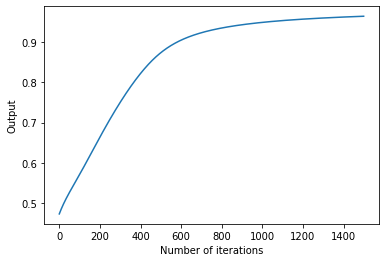

In [ ]:
# using a synthetic dataset which is normalised
import sklearn
from sklearn import datasets
input3,target3=sklearn.datasets.make_classification(n_samples=100, n_features=10,random_state=1)
target3=target3.reshape((100,1))

# splitting the dataset into train and test data
train_length3 = int(3*(len(input3)/4))

x_train3 = input3[:train_length3,:]
y_train3 = target3[:train_length3,:]

x_test3 = input3[train_length3:,:]
y_test3 = target3[train_length3:,:]
test_length3=len(y_test3)

M3=MLP()
m3lay1=Layer(10,"input",x_train3)
m3lay2=Layer(8,"hidden",m3lay1.get_output())
m3lay3=Layer(4,"hidden",m3lay2.get_output())
m3lay4=Layer(1,"output",m3lay3.get_output())
M3.addLayer(m3lay1)
M3.addLayer(m3lay2)
M3.addLayer(m3lay3)
M3.addLayer(m3lay4)
lout3=[]
number_of_iterations = 1500
for i in range(number_of_iterations):
  m3lay1Out=m3lay1.generate_output(x_train3)
  m3lay2Out=m3lay2.generate_output(m3lay1Out)
  m3lay3Out=m3lay3.generate_output(m3lay2Out)
  m3lay4Out=m3lay4.generate_output(m3lay3Out)
  lout3.append(m3lay4.get_output()[0][0])
  m3lay4.generate_delta(y_train3,train_length3)
  M3.generate_delta_hidden(m3lay3,2,train_length3)
  M3.generate_delta_hidden(m3lay2,1,train_length3)
  M3.backpropagate(train_length3,0.5)

m3lay1Out=m3lay1.generate_output(x_test3)
m3lay2Out=m3lay2.generate_output(m3lay1Out)
m3lay3Out=m3lay3.generate_output(m3lay2Out)
m3lay4Out=m3lay4.generate_output(m3lay3Out) 
plt.xlabel("Number of iterations")
plt.ylabel("Output")
plt.plot(np.arange(0,number_of_iterations),lout3) 

In [ ]:
print("Accuracy of Batch Learning: "+str(M3.accuracy(y_test3,m3lay4.get_output(),test_length3)))

**ON-LINE LEARNING**

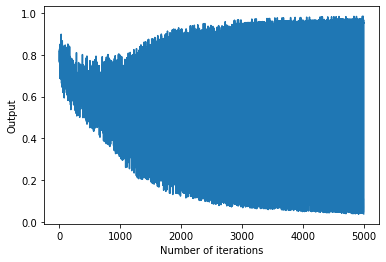

In [ ]:
M4=MLP()
m4lay1=Layer(10,"input",x_train3[0:1])
m4lay2=Layer(8,"hidden",m4lay1.get_output())
m4lay3=Layer(4,"hidden",m4lay2.get_output())
m4lay4=Layer(1,"output",m4lay3.get_output())
M4.addLayer(m4lay1)
M4.addLayer(m4lay2)
M4.addLayer(m4lay3)
M4.addLayer(m4lay4)
lout4=[]
for i in range(5000):
  rand_n= random.randint(0,train_length3-1)
  online_x_train3=x_train3[rand_n:rand_n+1,:]
  online_y_train3=y_train3[rand_n:rand_n+1,:]
  m4lay1Out=m4lay1.generate_output(online_x_train3)
  m4lay2Out=m4lay2.generate_output(m4lay1Out)
  m4lay3Out=m4lay3.generate_output(m4lay2Out)
  m4lay4Out=m4lay4.generate_output(m4lay3Out)
  lout4.append(m4lay4.get_output()[0][0])
  m4lay4.generate_delta(online_y_train3,1)
  M4.generate_delta_hidden(m4lay3,2,1)
  
  M4.generate_delta_hidden(m4lay2,1,1)
  M4.backpropagate(1,0.09)
m4lay1Out=m4lay1.generate_output(x_test3)
m4lay2Out=m4lay2.generate_output(m4lay1Out)
m4lay3Out=m4lay3.generate_output(m4lay2Out)
m4lay4Out=m4lay4.generate_output(m4lay3Out)
plt.xlabel("Number of iterations")
plt.ylabel("Output")
plt.plot(np.arange(0,5000),lout4)



In [ ]:
print("Accuracy of On-Line Learning: "+str(M4.accuracy(y_test3,m4lay4.get_output(),test_length3)))

## References
Heart Disease Dataset: https://www.mldata.io/dataset-details/heart_disease/

Code Implementation Reference: https://medium.com/@vdpatel/implementing-a-multi-layer-perceptron-neural-network-in-python-b22b5a3bdfa3